# <tt>synphot</tt>: Predicting photometric fluxes with an empirical spectrum

## Authors
Tiffany Jansen, Brett Morris, Pey Lian Lim, & Erik Tollerud

## Objectives
<ul>
    <li>Query data directly from other websites using <code>astropy.coordinates.Skycoord</code>, <code>astroquery.sdss</code>, and <code>tynt</code></li>
<li>Download a spectrum and construct a source spectrum object using <code>synphot.SourceSpectrum</code></li>
<li>Simulate bandpass throughput with <code>synphot.SpectralElement</code></li>
<li>Simulate the photometric observation with <code>synphot.Observation</code></li>
<li>Compute the expected fluxes from this observation with <code>synphot</code>'s <code>effstim()</code> function
</ul>

## Keywords
synphot, synthetic photometry, tynt, astropy, astroquery, astronomy

## Summary
In this tutorial we will:
<ol>
<li><a href="#sdss">Get the observed spectrum of our target from SDSS</a></li>
<li><a href="#source_spectrum">Construct a source spectrum object</a></li>
<li><a href="#bandpass">Create the bandpasses of observation</a></li>
<li><a href="#observe">Combine the spectrum with the bandpass throughput and "observe"</a></li>
<li><a href="#compare">Compare simulated flux to observed flux</a></li>
</ol>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

<a id="sdss"></a>
### 1. Download an observed spectrum from SDSS

In this example we choose the galaxy <a href="https://skyserver.sdss.org/dr12/en/tools/explore/Summary.aspx?id=1237662301903192106" target="_blank">IRAS F15163+4255 NW</a> which has a strong Halpha emission line.

To get the spectrum, first set the coordinates for the object:

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord

ra = 229.525575754 * u.degree
dec = 42.745853761 * u.degree
coords = SkyCoord(ra, dec)

Then use <a href="https://astroquery.readthedocs.io/en/latest/sdss/sdss.html">astroquery.sdss</a> to query the spectrum observed by SDSS:

In [4]:
from astroquery.sdss import SDSS
from synphot import units

spectrum_fits = SDSS.get_spectra(coordinates=coords)
data = spectrum_fits[0][1].data

wavelengths = 10 ** data['loglam'] * u.angstrom
flux = data['flux'] * 1e-17 * units.FLAM  # units are given in 10^-17 ergs/s/cm^2/AA

//anaconda/lib/python3.5/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "
//anaconda/lib/python3.5/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


<a id="source_spectrum"></a>
### 2. Construct a `synphot` source spectrum object from the empirical spectrum

Make the source spectrum object with <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">SourceSpectrum</a>:

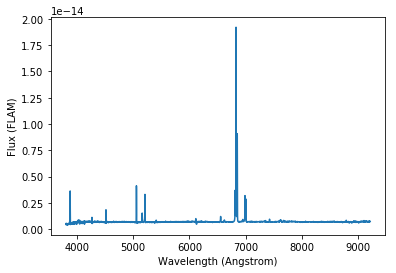

In [ ]:
from synphot.spectrum import SourceSpectrum
from synphot.models import Empirical1D

spectrum = SourceSpectrum(Empirical1D,
                          points=wavelengths, lookup_table=flux)

spectrum.plot(flux_unit='FLAM')

<a id="bandpass"></a>
### 3. Model the bandpasses with `tynt` and `synphot.spectrum`

We query the SDSS filter transmission functions from <a href="http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=voservice">SVO</a> using the <a href="https://tynt.readthedocs.io/en/latest/index.html">tynt</a> package. These transmission functions include the effect of the CCD's quantum efficiency on the spectrum.

To construct a bandpass from an array with `synphot`, use <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum">SpectralElement</a> with the Empirical1D model:

In [ ]:
import tynt
from synphot.spectrum import SpectralElement

sdss_bands = ['u', 'g', 'r', 'i', 'z']

f = tynt.FilterGenerator()

bandpasses = {}
for band in sdss_bands:
    filt = f.download_true_transmittance('SLOAN/SDSS.' + band)
    bp = SpectralElement(Empirical1D,
                         points=filt.wavelength,
                         lookup_table=filt.transmittance)
    bandpasses[band] = bp

    plt.plot(bp.waveset, bp(bp.waveset), label=band)
plt.legend(loc='upper right')
plt.show()


You can also construct a bandpass from a file using <tt>synphot</tt>'s <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum.SpectralElement.from_file">SpectralElement.from_file()</a>

<a id="observe"></a>
### 4. Model the observation with `synphot.observation`

To convolve the spectrum with the filters, use <a href="https://synphot.readthedocs.io/en/latest/synphot/observation.html">`synphot.observation`</a>:

In [ ]:
from synphot.observation import Observation

# zero point flux of sdss system
zero_point_star_equiv = u.zero_point_flux(3631.1 * u.Jy)

fluxes = {}
for band in sdss_bands:
    observation = Observation(spectrum, bandpasses[band], force='extrap')
    flux = observation.effstim('Jy')
    # SDSS uses nanomaggies as a flux unit. For more info, 
    # see: http://www.sdss3.org/dr8/algorithms/magnitudes.php
    fluxes[band] = flux.to(u.nanomaggy, zero_point_star_equiv)

In [ ]:
for band in sdss_bands:
    print(band + ' =', str(int(fluxes[band].value)) + ' nmgy')

<a id="compare"></a>
### 5. Compare the u,g,r,i,z empirical fluxes to what we predict with `synphot`

Get the fluxes measured by the SDSS fibers by using <a href="https://astroquery.readthedocs.io/en/latest/api/astroquery.sdss.SDSSClass.html#astroquery.sdss.SDSSClass.query_crossid">`astroquery.sdss.query_crossid`</a> and setting the photoObj to "fiberFlux_band". For a full list of photoObj fields, <a href="https://skyserver.sdss.org/dr12/en/help/browser/browser.aspx?cmd=description+PhotoObj+V#&&history=description+PhotoObj+V">see here</a>.

In [ ]:
model_flux = ['fiberFlux_' + band for band in sdss_bands]
flux_table = SDSS.query_crossid(coordinates = coords, photoobj_fields=model_flux)
sdss_fluxes = {}
for band in sdss_bands:
    # sdss fluxes are given in units of "nanomaggies"
    sdss_fluxes[band] = flux_table['fiberFlux_' + band] * u.nanomaggy

In [ ]:
sdss_fluxes

Compare the `synphot` fluxes to the observed fluxes by plotting on a 1-1 line:

In [ ]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(9, 7))

for band in sdss_bands:
    plt.scatter(sdss_fluxes[band], fluxes[band],
                s=100, label=band)

# one-to-one line
fluxrange = np.linspace(0, 550, 10)
plt.plot(fluxrange, fluxrange, color='black')
plt.plot(fluxrange, fluxrange * 0.9, color='black', ls='--', label='10% error')
plt.plot(fluxrange, fluxrange * 1.1, color='black', ls='--')

plt.ylabel('synphot flux (nmaggy)', size='14')
plt.xlabel('observed flux (nmaggy)', size='14')

plt.xlim(0, 550)
plt.ylim(0, 550)

plt.legend(prop={'size': 18})